# Notes

This notebook is for making the figure the supplementary figure that was in the bioarxiv version of the paper figure 6 A and figure 6 C.

# Imports

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.spatial import distance
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')

from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL, compute_pitch_angles
from kinematics import compute_signed_pec_z_difference, compute_phi_dot_from_raw_trajectories, compute_coordinate_origin_z
from post_processing import contiguous_regions
from windowed_prob_utils import return_overlapping_windows_for_timeframes, compute_windowed_distribution_array_from_1D_tseries
from windowed_prob_utils import get_fightbout_rectangle_info


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions 

In [3]:
def return_state_probabilities_from_state_tseries(state_tseries, numLabelledStates):
    ''' Return the probabilities of each state in the state_tseries. 
        Each value in state_tseries is between 0 and numLabelledStates-1, or NaN,
        or -1 if it was belonging to another cluster (nonlabelled cluster)
        Return the probability of each state as a vector, with the last entry being prob
        of another cluster, and NaN data excluded.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from -1,  
                   Can contains NaNs.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    state_probs: 1D array of shape (numLabelledStates+1,), containing the probability of 
                 each cluster idx and lastly the probability of nonlabelled clusters
    '''
    # add one state for -1 (nonlabelled cluster)
    numStates = numLabelledStates + 1
    # preallocate the output
    state_probs = np.zeros((numStates,))
    #  find the number of frames in total excluding NaN frames
    state_tseries_nanless = state_tseries[~np.isnan(state_tseries)]
    numFrames = state_tseries_nanless.shape[0]
    # if we have no non-nan frames, all probs are zero except the last
    if numFrames == 0:
        return state_probs
    else:
        # first compute main states probs
        for stateIdx in range(numLabelledStates):
            state_counts = np.where(state_tseries_nanless==stateIdx)[0].shape[0]
            state_probs[stateIdx] = state_counts / numFrames
        # now add the final NaN probability
        other_state_counts = np.where(state_tseries_nanless==-1)[0].shape[0]
        state_probs[-1] = other_state_counts / numFrames
        return state_probs


    
def compute_state_probabilities_in_time_windows(state_tseries, time_windows, numLabelledStates):
    ''' Compute the probability of each of the state indices in state_tseries, in
        each of the windows in time_windows.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from 0 to (numLabelledClusters-1)
                   for the labelled states, -1 for all nonlabelled states, and NaN for missing data.
    time_windows: array of shape (numWins,2), where each row contains a start frame
                  and a stop frame which define a region in time. The probabilities
                  are estimated in each of these regions in time.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    window_state_probabilities: a (numWinds, numLabelledStates+1) array containing the 
                                probability of each cluster idx and lastly the probability of 
                                nonlabelled cluster occuring. 
                                
    --- see also ---
    return_state_probabilities_from_state_tseries: 
    the function which does the main computation in each time window.
    
    '''
    numWins = time_windows.shape[0]
    window_state_probabilities = np.zeros((numWins, numLabelledStates+1)) # plus1 for the nonlabelled states
    for winIdx in range(numWins):
        w0,wE = time_windows[winIdx]
        win_data = state_tseries[w0:wE]
        win_state_probs = return_state_probabilities_from_state_tseries(win_data, numLabelledStates)
        window_state_probabilities[winIdx] = win_state_probs
    return window_state_probabilities

In [4]:
def return_region_win_state_probs(region_data, all_exp_window_state_probabilities, all_exp_time_windows, all_exp_numFrames):
    ''' Return the list over fight-bouts, containing the windowed state probabilities for the chosen region.
    
    --- args ---
    region_data: array (numBouts,3), where first col is exp idxs, 2nd and 3rd cols are the start/stop
                 frames of certain regions, e.g. 3 mins before a fightbout.
    
    all_exp_window_state_probabilities: the list over experiments, containing the windowed state probability of
                                        infomap clusters, e.g. each element of the list is a (numWins, 11) array,
                                        where 11 is the number of states and state vals sum to 1.
                                        
    all_exp_time_windows: the list over experiments, with elements being the time windows associated with the 
                          state probabilities in all_exp_window_state_probabilities.
                          
    all_exp_numFrames: a list over experiments containing the number of frames in each experiment.
                          
    --- return ---
    exps_region_win_state_probs: a list over fight bouts, where each element is a (numRegionWins,numStates) array
                                 of state proabilities for windows during the chosen region for a particular fight bout.
                                 
    --- see also ---
    find_time_window_indices_bounding_start_and_stop_frame()
    
    '''
    #exps_region_time_wins = []
    exps_region_win_state_probs = []

    skipped_bIdxs = []
    for bIdx in range(region_data.shape[0]):
        expIdx, t0, tE = region_data[bIdx]
        
        # if t0 is negative, exclude this fight bout
        # if tE is greater than the number of frames in the experiment, exclude fight bout
        if t0 < 0:
            skipped_bIdxs.append(bIdx)
            continue
        expnfs = expNumFrames[expIdx]
        if tE > expnfs:
            skipped_bIdxs.append(bIdx)
            continue

        exp_win_state_probs = all_exp_window_state_probabilities[expIdx]
        exp_time_wins = all_exp_time_windows[expIdx]

        desired_first_win_idx, desired_last_win_idx = find_time_window_indices_bounding_start_and_stop_frame(exp_time_wins, 
                                                                                                             t0, tE)

        #region_time_wins = exp_time_wins[desired_first_win_idx:desired_last_win_idx+1, :] #+1 to get the last win
        region_win_state_probs = np.copy(exp_win_state_probs[desired_first_win_idx:desired_last_win_idx+1, :])

        #exps_region_time_wins.append(region_time_wins)
        exps_region_win_state_probs.append(region_win_state_probs)
    
    
    return exps_region_win_state_probs



def find_time_window_indices_bounding_start_and_stop_frame(time_windows, startFrame, stopFrame):
    ''' Return the time window indices of which bound the startFrame and stopFrame.
    
    The idea is to allow for the parsing of time_windows, to choose only windows that contain
    no contributions for timepoints outside of the interval [startFrame, stopFrame]
    
    --- Example ---
    time_windows = np.array([[     0,   6000],
                            [   100,   6100],
                            [   200,   6200],
                            ...,
                            [711600, 717600],
                            [711700, 717700],
                            [711800, 717800]])
    startFrame = 36000
    stopFrame = 66000
                       
    desired_first_win_idx, desired_first_win_idx = f(time_windows, startFrame, stopFrame)
    time_windows[desired_first_win_idx] = array([36000, 42000])
    time_windows[desired_last_win_idx] = array([60000, 66000])                  
    
    -- returns --
    desired_first_win_idx, desired_first_win_idx: int, int
    
    '''
    desired_first_win_idx = np.where(time_windows[:,0] >= startFrame)[0][0]
    
    
    # for the end window, we need to do a check to make sure stopFrame is not
    # beyond our windows
    
    # if tE is beyond the end of the last window, use the last window
    if time_windows[:,1][-1] <= stopFrame:
        desired_last_win_idx = time_windows.shape[0] - 1
    # otherwise find the first window beyond tE
    else:
        desired_last_win_idx = np.where(time_windows[:,1] >= stopFrame)[0][0]
    return desired_first_win_idx, desired_last_win_idx



def return_overlapping_windows_for_timeframes(numFrames, window_size=200, window_step=50):
    ''' Given a number of frames, return an 2D array of window start-stop frames.
    '''
    # define, for clarity, the first window
    win0_start = 0
    win0_mid = int(window_size/2)
    win0_end = int(window_size)

    # find numWindows, by adding incrementally and watching the last frame
    last_frame_in_windows = win0_end
    numWindows = 1
    while last_frame_in_windows < (numFrames - window_step):
        numWindows += 1
        last_frame_in_windows = win0_end + (numWindows-1)*window_step

    # now fill-in the windows array of frame indices
    windows = np.zeros((numWindows, 2))
    windows[0, 0] = 0
    windows[0, 1] = win0_end
    for winIdx in range(1, numWindows):
        w0 = winIdx*window_step
        wF = w0 + window_size
        windows[winIdx, 0] = w0
        windows[winIdx, 1] = wF
    return windows.astype(int)

# load the tracking data

In [5]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

    


# load the post-processed tseries of infomap cluster idxs

In [6]:
# load
all_exps_edited_postProced_clusterIdx_tseries = []
postprocessed_all_exp_edited_cluster_tseries_savepath = os.path.join(os.path.dirname(infomap_data_loadpath),
                                                                     'postprocessed_exp_edited_clusterIdx_timeseries.h5')
with h5py.File(postprocessed_all_exp_edited_cluster_tseries_savepath, 'r') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        tseries = hf['{0}_clusterIdxs'.format(expName)][:]
        all_exps_edited_postProced_clusterIdx_tseries.append(tseries)
        
# make the master-set
clusterIdx_edited_postProced_tseries_master = np.concatenate(all_exps_edited_postProced_clusterIdx_tseries)
clusterIdx_edited_postProced_tseries_master.shape

(16044324,)

In [7]:


# colorlist without red and blue
colorlist = ['#ffe119', '#3cb44b',                    '#f58231', 
             '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', 
             '#469990', '#dcbeff', '#9A6324', '#800000', 
             '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'] 


In [8]:

# these are the state names of the clusterIdx_edited_postProced_tseries
all_state_names = ['circling',
                 'direct away',
                 'winner attack',
                 'loser attack',
                 'display',
                 'direct to',
                 'middle circling',
                 'L approach',
                 'W approach',
                 'parallel',
                 'non-fight clusters']

all_state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'L approach',
 'W approach',
 'parallel',
 'non-fight clusters']

In [9]:
len(all_state_names)

11

In [10]:
numLabelledStates = len(all_state_names)-1
numLabelledStates


10

In [11]:
# -1 represent nonFight clusters
# NaN data means missing data
np.unique(clusterIdx_edited_postProced_tseries_master[~np.isnan(clusterIdx_edited_postProced_tseries_master)])

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [12]:
totalNumStates = numLabelledStates+1

# Panel A

## rough

In [13]:
complete_labels = np.copy(all_exps_edited_postProced_clusterIdx_tseries[2])
complete_labels.shape

(501943,)

In [14]:
# numLabelledClusters = len(all_state_names)-1
# numLabelledClusters

In [15]:
f0 = 40005 
fE = f0 + 1000 #500
eth_numFrames = fE - f0

state_plot_order = [0,2,3,4,7,5]

In [16]:
plot_complete_labels = np.copy(complete_labels[f0:fE])

# --- Remove small contiguous regions --- #
MINSIZE = 5

plot_complete_labels_edited = np.copy(plot_complete_labels)

# loop over clusterIdxs, leaving -1 alone
for clusterIdx in range(numLabelledStates):

    # create a binary array
    clIdx_bin_arr = plot_complete_labels_edited == clusterIdx

    # get the regions and lenghts
    regions = contiguous_regions(clIdx_bin_arr)
    lengths = np.diff(regions, axis=1)[:,0]

    # NaN any regions smaller than MINSIZE in original array
    for regIdx in range(regions.shape[0]):
        regSize = lengths[regIdx]
        r0,rF = regions[regIdx]
        if regSize < MINSIZE:
            plot_complete_labels_edited[r0:rF] = np.NaN

    
    
# ------ get the time regions of each cluster --------#
cluster_time_regions = []
for i in state_plot_order:
    cls_frames = np.where(plot_complete_labels_edited==i)[0]
    cluster_time_regions.append(cls_frames)
    
    
    
    
plot_labels = [all_state_names[i] for i in state_plot_order]

ethogram_colors = [colorlist[i] for i in state_plot_order]

    
    
# ----- prepare the ethogram array ------ #
# minus -1 will represent the background color
eth_arr = np.ones((len(state_plot_order), eth_numFrames ))*-1

# prepare the colors for the ethogram
# white is the background (-1)
eth_colors = ['#FFFFFF'] + ethogram_colors

cmap = mpl.colors.ListedColormap(eth_colors)
norm = mpl.colors.BoundaryNorm([i for i in range(-1, len(state_plot_order)+1)], cmap.N)

# fill in the ethogram
for ii in range(len(state_plot_order)):
    
    cls_frames = cluster_time_regions[ii]
    
    for fIdx in cls_frames:
        eth_arr[ii, fIdx] = ii

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
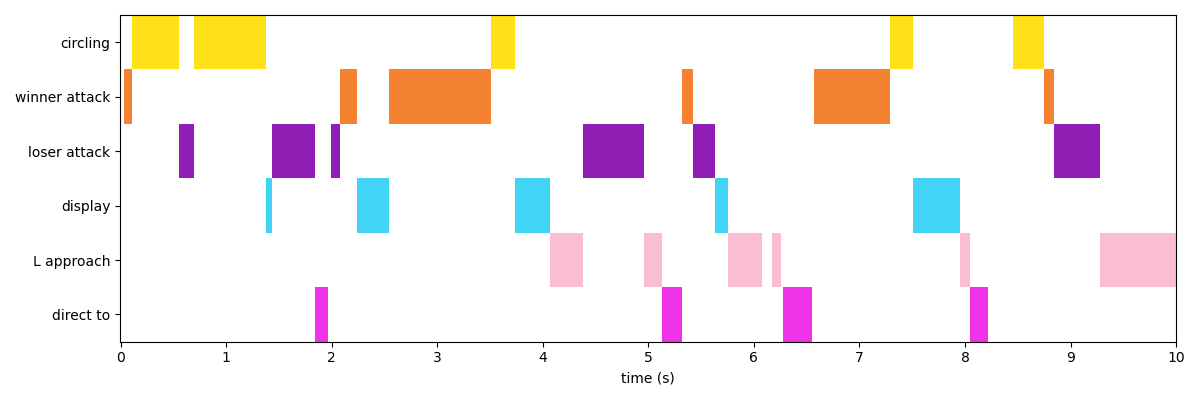

In [17]:
# ---- Plot --- #

fig, axs = plt.subplots(figsize=(12,4))

ax = axs
im = ax.imshow(eth_arr, aspect='auto', cmap=cmap, norm=norm, interpolation='none')
#fig.colorbar(im, orientation='vertical')


ax.set_yticks([i for i in range(len(state_plot_order))])
ax.set_yticklabels(plot_labels)

ax.set_xticks([0,100,200,300,400,500,600,700,800,900,1000])
ax.set_xticklabels(['0', '1', '2', '3', '4', '5','6','7','8','9','10'])

ax.set_xlabel('time (s)')

fig.tight_layout()


## paper version

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
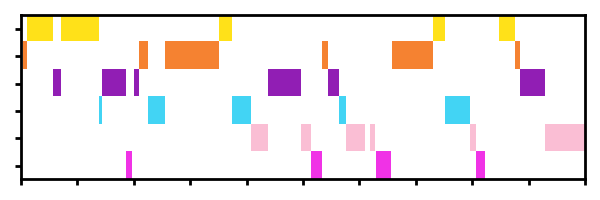

In [18]:
# ---- Plot --- #

fig, axs = plt.subplots(figsize=(6,2))


ax = axs
im = ax.imshow(eth_arr, aspect='auto', cmap=cmap, norm=norm, interpolation='none')

ax.set_yticks([i for i in range(len(state_plot_order))])
#ax.set_yticklabels(plot_labels)
ax.set_yticklabels([])

ax.set_xticks([0,100,200,300,400,500,600,700,800,900,1000])
#ax.set_xticklabels(['0', '1', '2', '3', '4', '5','6','7','8','9','10'])
ax.set_xticklabels([])

#ax.set_xlabel('time (s)')
ax.set_xlabel('')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.xaxis.set_tick_params(width=2, length=4)
ax.yaxis.set_tick_params(width=2, length=4)

fig.tight_layout()

#fig.savefig('/home/liam/temp/image_transfer/fig6_A_ethogram_new.png', dpi=300, transparent=True)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
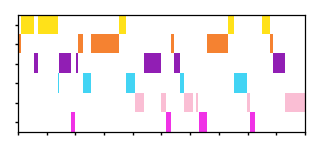

In [19]:
# ---- Plot --- #

fig, axs = plt.subplots(figsize=(3.2, 1.5))


ax = axs
im = ax.imshow(eth_arr, aspect='auto', cmap=cmap, norm=norm, interpolation='none')

ax.set_yticks([i for i in range(len(state_plot_order))])
#ax.set_yticklabels(plot_labels)
ax.set_yticklabels([])

ax.set_xticks([0,100,200,300,400,500,600,700,800,900,1000])
#ax.set_xticklabels(['0', '1', '2', '3', '4', '5','6','7','8','9','10'])
ax.set_xticklabels([])

#ax.set_xlabel('time (s)')
ax.set_xlabel('')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.9)
ax.xaxis.set_tick_params(width=1, length=2)
ax.yaxis.set_tick_params(width=1, length=2)

fig.tight_layout()

fig.savefig('/home/liam/temp/image_transfer/SI_fig_short_long_A.png', dpi=900, transparent=True)

# Panel B

## compute the windowed probabilties

In [20]:
# compute the windowed state probabilities for each experiment
window_size= 6000 #6000
window_step=100

all_exp_window_state_probabilities = []
all_exp_time_windows = []

for expIdx in range(len(expNames)):
    expName = expNames[expIdx]
    print(expName)
    exp_cls_tseries = np.copy(all_exps_edited_postProced_clusterIdx_tseries[expIdx])
    exp_numFrames = exp_cls_tseries.shape[0]
    exp_time_windows = return_overlapping_windows_for_timeframes(exp_numFrames, window_size=window_size, window_step=window_step)
    exp_window_state_probabilities = compute_state_probabilities_in_time_windows(exp_cls_tseries, exp_time_windows, numLabelledStates)
    all_exp_window_state_probabilities.append(exp_window_state_probabilities)
    all_exp_time_windows.append(exp_time_windows)

FishTank20200127_143538
FishTank20200129_140656
FishTank20200130_153857
FishTank20200130_181614
FishTank20200207_161445
FishTank20200213_154940
FishTank20200214_153519
FishTank20200217_160052
FishTank20200218_153008
FishTank20200316_163320
FishTank20200327_154737
FishTank20200330_161100
FishTank20200331_162136
FishTank20200520_152810
FishTank20200521_154541
FishTank20200525_161602
FishTank20200526_160100
FishTank20200527_152401
FishTank20200824_151740
FishTank20200828_155504
FishTank20200902_160124
FishTank20200903_160946


## plot rough

In [21]:
# define a new order for plotting
new_plot_order = [2,3,0,4,8,7,1,5,6,9,10]
[all_state_names[i] for i in new_plot_order]


['winner attack',
 'loser attack',
 'circling',
 'display',
 'W approach',
 'L approach',
 'direct away',
 'direct to',
 'middle circling',
 'parallel',
 'non-fight clusters']

In [22]:
# a dcionary which maps state indexs to the row i want to draw them
correct_place_dictionary = dict(zip(new_plot_order, np.arange(0, numLabelledStates+1)))
correct_place_dictionary

{2: 0, 3: 1, 0: 2, 4: 3, 8: 4, 7: 5, 1: 6, 5: 7, 6: 8, 9: 9, 10: 10}

In [24]:
figure_bout_info = np.copy(fight_bout_info_noDurThresh)

# the set of expIdxs that have contributions to figure_bout_info
chosen_expIdxs = np.unique(figure_bout_info[:,0])

numBouts = figure_bout_info.shape[0]

figure_bout_info.shape

(33, 4)

In [25]:
expIdx = 2
exp_fight_bout_lims = figure_bout_info[figure_bout_info[:,0]==expIdx][:, 1:3]
exp_fight_bout_lims

array([[ 31500, 175400],
       [301300, 319600]])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
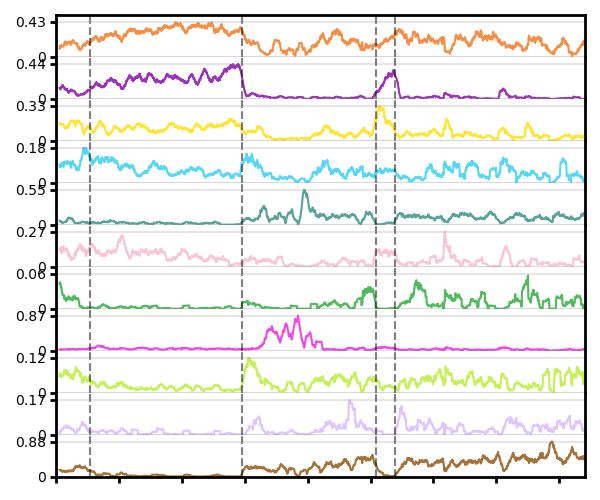

In [26]:
expIdx = 2
#imsavepath = '/mnt/e/OneDrive/illustrator_projects/paper_figures/figure6/panel_A_v2.png'
exp_fight_bout_lims = figure_bout_info[figure_bout_info[:,0]==expIdx][:, 1:3]


t0 = time.time()


# ---- parse and prepare data ------
expName = expNames[expIdx]
#print(expName)
# get time windows
exp_numFrames = (all_exps_edited_postProced_clusterIdx_tseries[expIdx]).shape[0]
exp_time_windows = return_overlapping_windows_for_timeframes(exp_numFrames, window_size=window_size, window_step=window_step)
window_mids = np.mean(exp_time_windows, axis=1)
numWins = exp_time_windows.shape[0]
# get the probabilities (computed cell above)
exp_windowed_state_probabilities = all_exp_window_state_probabilities[expIdx]
# get colors
state_colors = [colorlist[i] for i in range(numLabelledStates+1)] #plus 1 for non-fight-clusters


# find the max y vals, for yrange and ytickmax
states_y_max = np.zeros((totalNumStates,))
states_y_tick_max = np.zeros((totalNumStates,))
for stateIdx in range(totalNumStates):
    maxval = np.round(np.max(exp_windowed_state_probabilities[:,stateIdx]), 2)
    states_y_max[stateIdx] = maxval*1.2
    states_y_tick_max[stateIdx] = maxval


# ----------- prepare the figure ----------#

    

# prepare the figure
nrows = numLabelledStates+1

fig = plt.figure(figsize=(6,5))
gs = fig.add_gridspec(nrows=nrows, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

# loop over rows to draw clusters, but use new_plot_order
# to draw them on the right axis
for i in range(nrows):    
    
    correct_axis_idx = correct_place_dictionary[i]
    ax = axs[correct_axis_idx]
    
    # everything else from now on uses i
    
    stateIdx = i
    ax.plot(window_mids, exp_windowed_state_probabilities[:,stateIdx], 
            color=state_colors[stateIdx], alpha=0.9, linewidth=1.5, label='                  ')

    
    
    # plot the fight boundaries
    for boutIdx in range(exp_fight_bout_lims.shape[0]):
        f0, fE = exp_fight_bout_lims[boutIdx, 0], exp_fight_bout_lims[boutIdx, 1]
        ax.axvline(f0, linestyle='--', color='black', alpha=0.5)
        ax.axvline(fE, linestyle='--', color='black', alpha=0.5)


    # xticks
    mins_between_ticks = 10
    numWins = exp_time_windows.shape[0]
    xtick_max = int(numWins*window_step)
    exp_numMins = (exp_time_windows[-1][-1] / 100)/60
    xsteps_per_min = xtick_max/exp_numMins
    xticks = np.arange(0, xtick_max, mins_between_ticks*xsteps_per_min)
    xticklabels = [mins_between_ticks*i for i in range(len(xticks))]
    ax.set_xticks(xticks);
    ax.set_xticklabels(xticklabels);
    
    # # yticks
    # plot_max_y = np.max(exp_windowed_state_probabilities[:,stateIdx])
    # print(all_state_names[i], plot_max_y)
    # ax.set_yticks([0, plot_max_y])
    # ax.set_yticklabels([0, np.round(plot_max_y, decimals=2)])

    # plot limits
    ax.set_xlim(0, window_mids[-1])
    ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
    # set the yticks
    ax.set_yticks([0, states_y_tick_max[stateIdx]])
    ax.set_yticklabels([0, states_y_tick_max[stateIdx]])
    
    # make the legend
    ax.legend(frameon=False, loc='best')

    # axes labels
    ax.set_ylabel(all_state_names[i]+'\n prob')
    
    # tick params
    ax.xaxis.set_tick_params(width=2, length=4)
    ax.yaxis.set_tick_params(width=2, length=4)
    
    # make the left and rights thicker for each axis
    for axis in ['left','right']:
        ax.spines[axis].set_linewidth(2)
        
    # turn off all the interior x axes    
    for ii in range(numLabelledStates):
        axs[ii].spines['bottom'].set_visible(False)
        axs[ii+1].spines['top'].set_visible(False)
        
    # set the gridlines
    #ax.grid(alpha=0.3)
    ax.axhline(y=0, color='grey', alpha=0.3)
    ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
        
    ### EXTRAS TURN OFF PLOT ILLUSTRATOR VERSION ####
    #ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.get_legend().remove()
    
    
    
# ----------------------------------------------------#


# make the very top and very bottoms lines thicker
ax = axs[0]
for axis in ['top']:
    ax.spines[axis].set_linewidth(2)
ax = axs[-1]
for axis in ['bottom']:
    ax.spines[axis].set_linewidth(2)


fig.tight_layout()

#fig.savefig(imsavepath, dpi=300, transparent=False)

## paper version

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
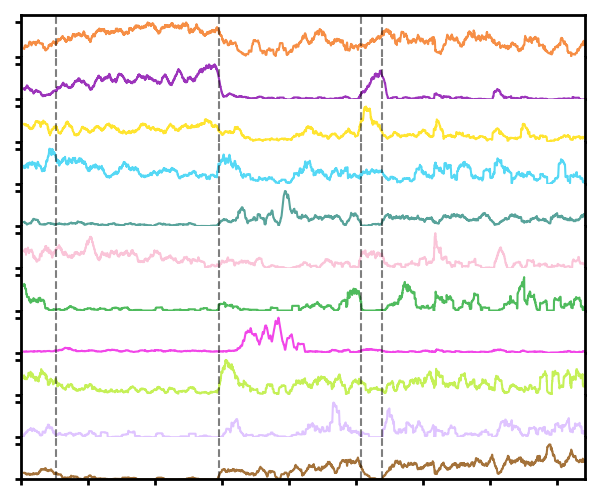

In [27]:
expIdx = 2
imsavepath = '/home/liam/temp/image_transfer/fig6_panel_A_v4.png'
exp_fight_bout_lims = figure_bout_info[figure_bout_info[:,0]==expIdx][:, 1:3]

t0 = time.time()


# ---- parse and prepare data ------
expName = expNames[expIdx]
#print(expName)
# get time windows
exp_numFrames = (all_exps_edited_postProced_clusterIdx_tseries[expIdx]).shape[0]
exp_time_windows = return_overlapping_windows_for_timeframes(exp_numFrames, window_size=window_size, window_step=window_step)
window_mids = np.mean(exp_time_windows, axis=1)
numWins = exp_time_windows.shape[0]
# get the probabilities (computed cell above)
exp_windowed_state_probabilities = all_exp_window_state_probabilities[expIdx]
# get colors
state_colors = [colorlist[i] for i in range(numLabelledStates+1)] #plus 1 for non-fight-clusters


# find the max y vals, for yrange and ytickmax
states_y_max = np.zeros((totalNumStates,))
states_y_tick_max = np.zeros((totalNumStates,))
for stateIdx in range(totalNumStates):
    maxval = np.round(np.max(exp_windowed_state_probabilities[:,stateIdx]), 2)
    states_y_max[stateIdx] = maxval*1.2
    states_y_tick_max[stateIdx] = maxval


# ----------- prepare the figure ----------#

    

# prepare the figure
nrows = numLabelledStates+1

fig = plt.figure(figsize=(6,5))
gs = fig.add_gridspec(nrows=nrows, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

# loop over rows to draw clusters, but use new_plot_order
# to draw them on the right axis
for i in range(nrows):    
    
    correct_axis_idx = correct_place_dictionary[i]
    ax = axs[correct_axis_idx]
    
    # everything else from now on uses i
    
    stateIdx = i
    ax.plot(window_mids, exp_windowed_state_probabilities[:,stateIdx], 
            color=state_colors[stateIdx], alpha=0.9, linewidth=1.5, label='                  ')

    
    
    # plot the fight boundaries
    for boutIdx in range(exp_fight_bout_lims.shape[0]):
        f0, fE = exp_fight_bout_lims[boutIdx, 0], exp_fight_bout_lims[boutIdx, 1]
        ax.axvline(f0, linestyle='--', color='black', alpha=0.5)
        ax.axvline(fE, linestyle='--', color='black', alpha=0.5)


    # xticks
    mins_between_ticks = 10
    numWins = exp_time_windows.shape[0]
    xtick_max = int(numWins*window_step)
    exp_numMins = (exp_time_windows[-1][-1] / 100)/60
    xsteps_per_min = xtick_max/exp_numMins
    xticks = np.arange(0, xtick_max, mins_between_ticks*xsteps_per_min)
    xticklabels = [mins_between_ticks*i for i in range(len(xticks))]
    ax.set_xticks(xticks);
    ax.set_xticklabels(xticklabels);
    
    # # yticks
    # plot_max_y = np.max(exp_windowed_state_probabilities[:,stateIdx])
    # print(all_state_names[i], plot_max_y)
    # ax.set_yticks([0, plot_max_y])
    # ax.set_yticklabels([0, np.round(plot_max_y, decimals=2)])

    # plot limits
    ax.set_xlim(0, window_mids[-1])
    ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
    # set the yticks
    ax.set_yticks([0, states_y_tick_max[stateIdx]])
    ax.set_yticklabels([0, states_y_tick_max[stateIdx]])
    
    # make the legend
    ax.legend(frameon=False, loc='best')

    # axes labels
    ax.set_ylabel(all_state_names[i]+'\n prob')
    
    # tick params
    ax.xaxis.set_tick_params(width=2, length=4)
    ax.yaxis.set_tick_params(width=2, length=4)
    
    # make the left and rights thicker for each axis
    for axis in ['left','right']:
        ax.spines[axis].set_linewidth(2)
        
    # turn off all the interior x axes    
    for ii in range(numLabelledStates):
        axs[ii].spines['bottom'].set_visible(False)
        axs[ii+1].spines['top'].set_visible(False)
        
    # set the gridlines
    #ax.grid(alpha=0.3)
    #ax.axhline(y=0, color='grey', alpha=0.3)
    #ax.axhline(y=states_y_tick_max[stateIdx], color='grey', alpha=0.2)
        
    ### EXTRAS TURN OFF PLOT ILLUSTRATOR VERSION ####
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.get_legend().remove()
    
    
    
# ----------------------------------------------------#


# make the very top and very bottoms lines thicker
ax = axs[0]
for axis in ['top']:
    ax.spines[axis].set_linewidth(2)
ax = axs[-1]
for axis in ['bottom']:
    ax.spines[axis].set_linewidth(2)


fig.tight_layout()

#fig.savefig(imsavepath, dpi=300, transparent=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
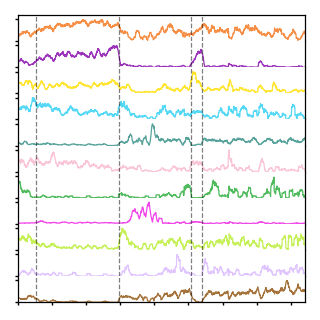

In [28]:
expIdx = 2
imsavepath = '/home/liam/temp/image_transfer/SI_fig_short_long_B.png'
exp_fight_bout_lims = figure_bout_info[figure_bout_info[:,0]==expIdx][:, 1:3]

t0 = time.time()


# ---- parse and prepare data ------
expName = expNames[expIdx]
#print(expName)
# get time windows
exp_numFrames = (all_exps_edited_postProced_clusterIdx_tseries[expIdx]).shape[0]
exp_time_windows = return_overlapping_windows_for_timeframes(exp_numFrames, window_size=window_size, window_step=window_step)
window_mids = np.mean(exp_time_windows, axis=1)
numWins = exp_time_windows.shape[0]
# get the probabilities (computed cell above)
exp_windowed_state_probabilities = all_exp_window_state_probabilities[expIdx]
# get colors
state_colors = [colorlist[i] for i in range(numLabelledStates+1)] #plus 1 for non-fight-clusters


# find the max y vals, for yrange and ytickmax
states_y_max = np.zeros((totalNumStates,))
states_y_tick_max = np.zeros((totalNumStates,))
for stateIdx in range(totalNumStates):
    maxval = np.round(np.max(exp_windowed_state_probabilities[:,stateIdx]), 2)
    states_y_max[stateIdx] = maxval*1.2
    states_y_tick_max[stateIdx] = maxval


# ----------- prepare the figure ----------#

    

# prepare the figure
nrows = numLabelledStates+1

fig = plt.figure(figsize=(3.2,3.2))
gs = fig.add_gridspec(nrows=nrows, hspace=0)
axs = gs.subplots(sharex=False, sharey=False)

# loop over rows to draw clusters, but use new_plot_order
# to draw them on the right axis
for i in range(nrows):    
    
    correct_axis_idx = correct_place_dictionary[i]
    ax = axs[correct_axis_idx]
    
    # everything else from now on uses i
    stateIdx = i
    ax.plot(window_mids, exp_windowed_state_probabilities[:,stateIdx], 
            color=state_colors[stateIdx], alpha=0.9, linewidth=0.9, label='                  ')

    
    # plot the fight boundaries
    for boutIdx in range(exp_fight_bout_lims.shape[0]):
        f0, fE = exp_fight_bout_lims[boutIdx, 0], exp_fight_bout_lims[boutIdx, 1]
        ax.axvline(f0, linestyle='--', color='black', linewidth=0.9, alpha=0.5)
        ax.axvline(fE, linestyle='--', color='black', linewidth=0.9, alpha=0.5)


    # xticks
    mins_between_ticks = 10
    numWins = exp_time_windows.shape[0]
    xtick_max = int(numWins*window_step)
    exp_numMins = (exp_time_windows[-1][-1] / 100)/60
    xsteps_per_min = xtick_max/exp_numMins
    xticks = np.arange(0, xtick_max, mins_between_ticks*xsteps_per_min)
    xticklabels = [mins_between_ticks*i for i in range(len(xticks))]
    
    # only set xticks for the last row
    if i == (nrows-1):
        ax.set_xticks(xticks);
        #ax.set_xticklabels(xticklabels);
    else:
        ax.set_xticks([]);

    # plot limits
    ax.set_xlim(0, window_mids[-1])
    ax.set_ylim(bottom=0, top=states_y_max[stateIdx])
    
    # set the yticks
    ax.set_yticks([0, states_y_tick_max[stateIdx]])
    ax.set_yticklabels([0, states_y_tick_max[stateIdx]])
    
    # make the legend
    ax.legend(frameon=False, loc='best')

    # axes labels
    ax.set_ylabel(all_state_names[i]+'\n prob')
    
    # tick params
    ax.xaxis.set_tick_params(width=1, length=2)
    ax.yaxis.set_tick_params(width=1, length=2)
    
    # make the left and rights thicker for each axis
    for axis in ['left','right']:
        ax.spines[axis].set_linewidth(2)
        
    # turn off all the interior x axes    
    for ii in range(numLabelledStates):
        axs[ii].spines['bottom'].set_visible(False)
        axs[ii+1].spines['top'].set_visible(False)
        
        
    ### EXTRAS TURN OFF PLOT ILLUSTRATOR VERSION ####
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.get_legend().remove()
    
    # boundaries
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.9)
    
fig.tight_layout()

fig.savefig(imsavepath, dpi=900, transparent=True)